<a href="https://colab.research.google.com/github/Rafiy27/Tugas-Akhir-Hate-Speech/blob/main/Yet_another_copy_of_TA_Model_(Tanpa_GA)_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Library

In [ ]:
!pip install pandas openpyxl fasttext tensorflow scikit-learn

# Import Dataset

In [ ]:
import pandas as pd

# Memastikan file dataset tersedia sebelum membaca
try:
    df = pd.read_excel("DatasetTA.xlsx")
except FileNotFoundError:
    print("File dataset tidak ditemukan. Pastikan file sudah diunggah dengan benar.")
    exit()

df.columns

Index(['id_str', 'conversation_id_str', 'full_text', 'Label_Putri',
       'Label_Dea', 'Label_Rafi', 'Label_Final'],
      dtype='object')

In [ ]:
data = df['full_text']
labels = df['Label_Final']

# Pre Processing Data

## Data Cleaning

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Menghapus tautan
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Menghapus emoji

    return text.lower().strip()

data = data.apply(clean_text)

## Case Folding

In [ ]:
data = data.str.lower()

## Tokenizing

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

data = data.apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Filtering dengan Stop Words

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))
data = data.apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stemming

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
data = data.apply(lambda x: [stemmer.stem(word) for word in x])
data = data.apply(lambda x: ' '.join(x))

In [ ]:
data

0                       android_ak_47 ani orang campu aja
1       ani blm kampany bawaslu sdh edar sm berantai m...
2       kosim__ ngusung ani sbg gub dki pk gerindrapra...
3       android_ak_47 malu klo tdk milih ani kerusakan...
4       msaid_didu yg salah ttg kegagalan food estat y...
                              ...                        
6506    ani baswedan berani jujur kemiskinan sesungguh...
6507    lisaamartatara6 pilih ani indonesia adil makmu...
6508    ilhamjati4 duren___ cakiminow ani salah hitung...
6509    tvonenew warga jakarta dukung aniessemoga pres...
6510    javeed_lelet jalan santai diubah jalan sehat d...
Name: full_text, Length: 6511, dtype: object

In [ ]:
labels

0       0
1       0
2       0
3       0
4       0
       ..
6506    0
6507    0
6508    0
6509    0
6510    0
Name: Label_Final, Length: 6511, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Menggunakan TF-IDF untuk mendapatkan kata-kata kunci
tfidf_vectorizer = TfidfVectorizer(max_features=10)  # Anda bisa mengatur jumlah kata kunci yang ingin ditemukan
tfidf_matrix = tfidf_vectorizer.fit_transform(data)

# Mendapatkan daftar kata kunci
feature_names = tfidf_vectorizer.get_feature_names_out()
dense = tfidf_matrix.todense()
keywords_df = pd.DataFrame(dense, columns=feature_names)

print("Daftar Kata Kunci:")
print(keywords_df.head())

Daftar Kata Kunci:
       aja       ani  baswedan  gak  ganjar  indonesia  prabowo  presiden  \
0  0.95882  0.284015       0.0  0.0     0.0   0.000000      0.0       0.0   
1  0.00000  1.000000       0.0  0.0     0.0   0.000000      0.0       0.0   
2  0.00000  1.000000       0.0  0.0     0.0   0.000000      0.0       0.0   
3  0.00000  0.283026       0.0  0.0     0.0   0.959112      0.0       0.0   
4  0.00000  0.398775       0.0  0.0     0.0   0.000000      0.0       0.0   

    ya        yg  
0  0.0  0.000000  
1  0.0  0.000000  
2  0.0  0.000000  
3  0.0  0.000000  
4  0.0  0.917049  


# Wordclouds

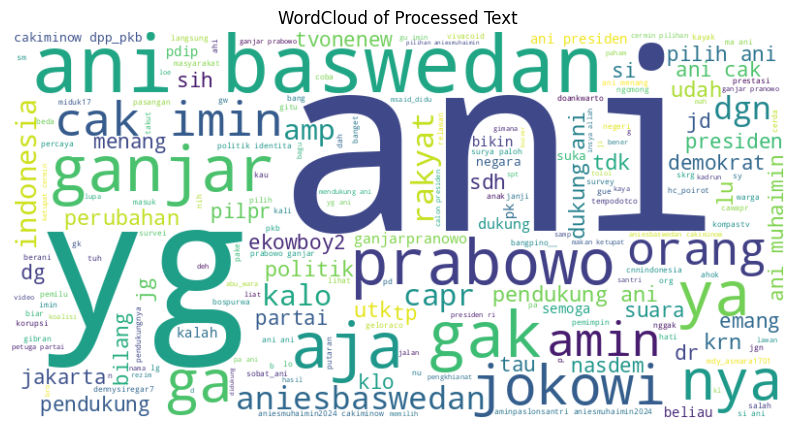

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the processed text into a single string
text_combined = ' '.join(data)

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_combined)

# Display the WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('WordCloud of Processed Text')
plt.show()

# Fast Text Feature Extraction

In [ ]:
import fasttext.util
import os
import numpy as np

# Path untuk model FastText
model_path = '/content/cc.id.300.bin'

# Cek apakah model sudah ada
if not os.path.exists(model_path):
    print("Downloading FastText model...")
    fasttext.util.download_model('id', if_exists='ignore', model_name='cc.id.300')
else:
    print("FastText model already exists!")

ft = fasttext.load_model(model_path)

data_vectors = [ft.get_sentence_vector(tweet) for tweet in data]
data_vectors = np.array(data_vectors)

FastText model already exists!


# TF IDF Feature Expansion

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
data_tfidf = tfidf_vectorizer.fit_transform(data).toarray()

# Menggabungkan Fast Text dan TF IDF

In [ ]:
data_combined = np.concatenate([data_vectors, data_tfidf], axis=1)

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_combined, labels, test_size=0.2, random_state=42)

# Menangani Oversampling / Ketidakseimbangan Data

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(data_combined, labels)

# CNN Model

## Melatih Model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(data_combined.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with EarlyStopping callback and save history
history = model.fit(
    X_resampled,
    y_resampled,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/1000
177/177 [==============================] - 4s 17ms/step - loss: 0.3826 - accuracy: 0.8391 - val_loss: 0.0830 - val_accuracy: 0.9777
Epoch 2/1000
177/177 [==============================] - 3s 19ms/step - loss: 0.1106 - accuracy: 0.9639 - val_loss: 0.0341 - val_accuracy: 0.9885
Epoch 3/1000
177/177 [==============================] - 2s 13ms/step - loss: 0.0548 - accuracy: 0.9847 - val_loss: 0.0163 - val_accuracy: 0.9962
Epoch 4/1000
177/177 [==============================] - 2s 13ms/step - loss: 0.0332 - accuracy: 0.9908 - val_loss: 0.0112 - val_accuracy: 0.9977
Epoch 5/1000
177/177 [==============================] - 2s 13ms/step - loss: 0.0223 - accuracy: 0.9949 - val_loss: 0.0058 - val_accuracy: 0.9985
Epoch 6/1000
177/177 [==============================] - 2s 12ms/step - loss: 0.0187 - accuracy: 0.9958 - val_loss: 0.0053 - val_accuracy: 0.9985
Epoch 7/1000
177/177 [==============================] - 3s 16ms/step - loss: 0.0151 - accuracy: 0.9960 - val_loss: 0.0076 - val_ac

## Visualisasi Model

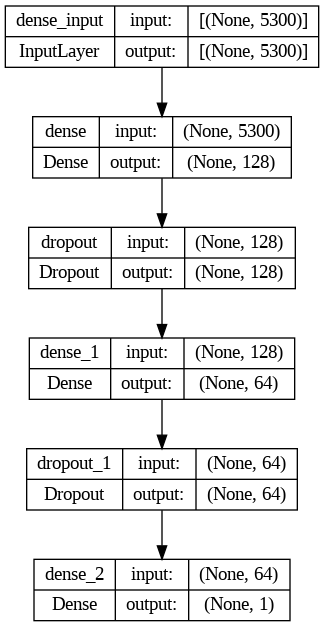

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Evaluation

## Model Prediction vs Actual Data

Model Loss: 0.0031
Model Accuracy: 99.85%
41/41 [==============================] - 0s 3ms/step


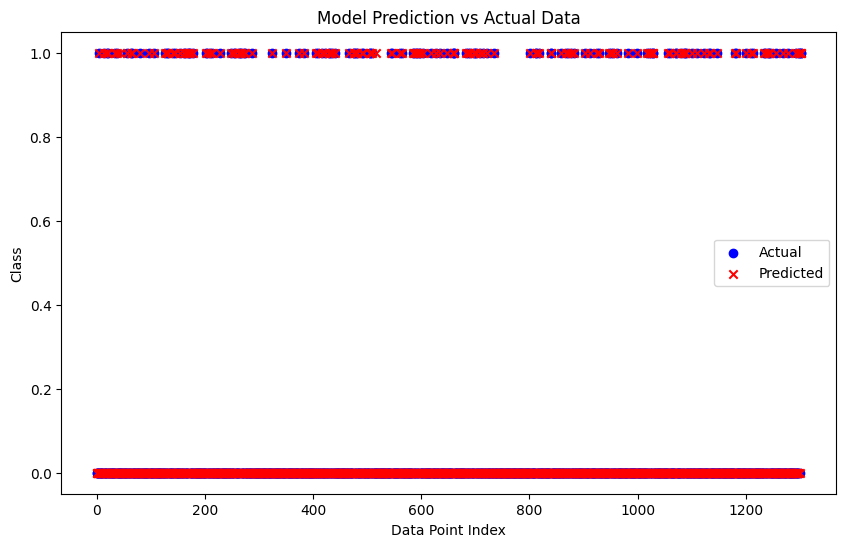

In [ ]:
import matplotlib.pyplot as plt

# Evaluasi model pada data test
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Model Loss: {loss:.4f}")
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Prediksi pada data test
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Plotting
plt.figure(figsize=(10, 6))

# Plot data aktual
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')

# Plot prediksi
plt.scatter(range(len(y_pred_classes)), y_pred_classes, color='red', marker='x', label='Predicted')

plt.title('Model Prediction vs Actual Data')
plt.xlabel('Data Point Index')
plt.ylabel('Class')
plt.legend()
plt.show()

## Model Loss and Model Accuracy

Model Loss: 0.0031
Model Accuracy: 99.85%


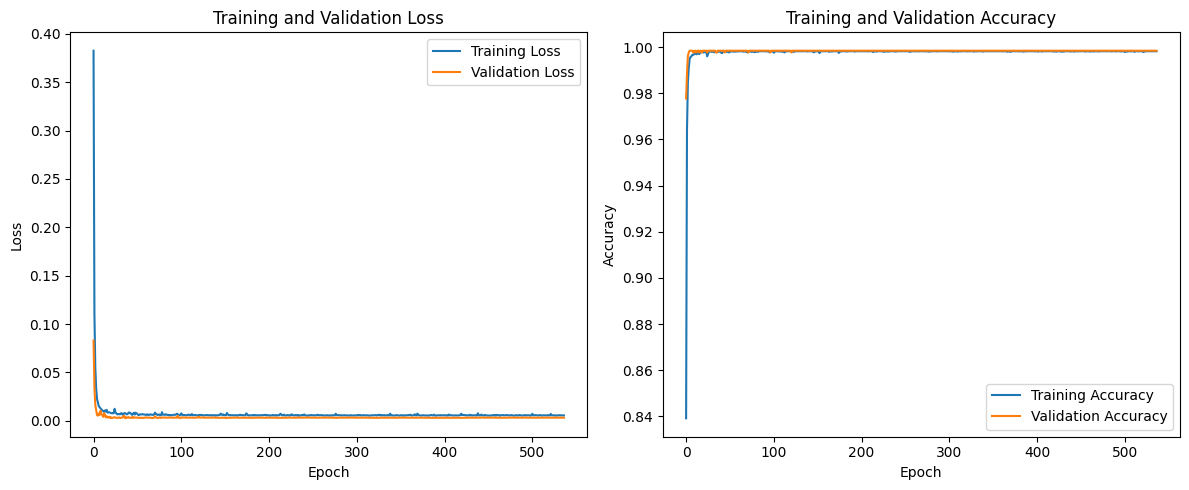

In [ ]:
# Evaluasi model pada data test
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Loss: {loss:.4f}")
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluating overfit or underfit
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Find the epoch with the minimum validation loss (best validation point)
best_epoch = validation_loss.index(min(validation_loss))

print(f"Best Validation Loss at Epoch {best_epoch + 1}")

# Check if the model is overfitting, underfitting, or optimal
if training_loss[best_epoch] < validation_loss[best_epoch]:
    print("Model is likely overfitting. The training loss is significantly lower than the validation loss, indicating that the model is memorizing the training data.")
elif training_loss[best_epoch] > validation_loss[best_epoch]:
    print("Model is likely underfitting. The training loss is higher than the validation loss, suggesting the model's inability to learn from the training data.")
else:
    print("Model is performing optimally or the determination is inconclusive. Both training and validation losses are close, indicating balanced performance.")

Best Validation Loss at Epoch 37
Model is likely underfitting. The training loss is higher than the validation loss, suggesting the model's inability to learn from the training data.


In [ ]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.0031
Test Accuracy: 99.85%


## Accuracy, Precision, Recall

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

41/41 [==============================] - 0s 5ms/step
Accuracy: 0.9984650805832693
Precision: 0.9864864864864865
Recall: 1.0


## Confusion Matrix

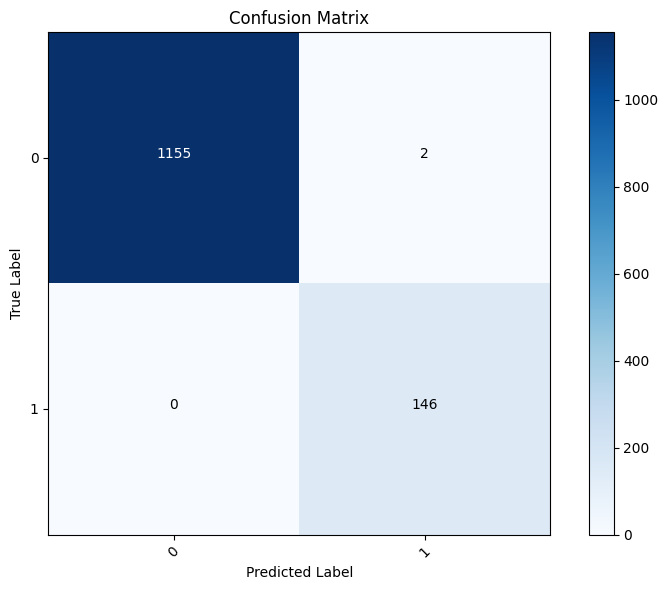

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(['0', '1']))  # Mengganti label
plt.xticks(tick_marks, ['0', '1'], rotation=45)  # Mengganti label
plt.yticks(tick_marks, ['0', '1'])  # Mengganti label
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()